In [4]:
%matplotlib inline

# Background

This is a version of the Dipy Tracking Quickstart Tutorial for python newbies (http://nipy.org/dipy/examples_built/tracking_quick_start.html#example-tracking-quick-start) for beginners to python

We are using an ipython notebook to run tracking because you can view your results with your code step-by-step. The first line (%matplotlib inline) is run to make figures show inline

To run a line of code, click on it and hold down the shift key while you press enter/return

NOTE: We assume that you have eddy-corrected (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy) (and if you can susceptibility-corrected; https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/topup) your data



# Imports

In [5]:
# os has lots of tools for working with the operating system (mkdir, ls)
# https://docs.python.org/2/library/os.html
import os

# glob allows you to list paths with wildcards
from glob import glob

# nibabel helps us load and save filetypes in neuroimaging
# http://nipy.org/nibabel/
import nibabel as nib

# nilearn has really nice plotting
import nilearn.plotting as nip

# gradient table will be used to load our bvalues and bvectors
from dipy.data import gradient_table

# this will display png's inline so we can see snapshots of our results
from IPython.display import Image

# length function
from dipy.tracking.utils import length

# imports from the Dipy tracking quickstart tutorial
import numpy as np
from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.direction import peaks_from_model
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere
from dipy.segment.mask import median_otsu
from dipy.viz import actor, window
from dipy.io.image import save_nifti
from nibabel.streamlines import save as save_trk
from nibabel.streamlines import Tractogram
from dipy.tracking.streamline import Streamlines

Choose whether or not you want interactive windows to pop up, or just snapshots saved

In [6]:
interactive = False

# Find our data

FOR YOUR DATA: EDIT THIS SECTION TO MAKE SURE YOU GET THE THREE FILES: BVALUE, BVECTOR, AND NIFTI

In [7]:
data_directory = '/Users/kesshijordan/ref_data/tutorial_data'

List the contents of the directory (ls)

In [8]:
contents_of_data_directory = os.listdir(data_directory)
contents_of_data_directory

['mydata_b2000_SC_EC.nii.gz',
 'mydata_b2000_SC_EC.bval',
 'mydata_b2000_SC_EC.nii',
 'mydata_b2000_SC_EC_b0.nii.gz',
 'mydata_b2000_SC_EC.bvec',
 'mydata_b2000_SC_EC_mask.nii.gz']

Option 1: addition of strings will combine them and produce one string

In [9]:
data_path = data_directory+'/mydata_b2000_SC_EC.nii.gz'
data_path

'/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC.nii.gz'

Option 2: We can put our path together by joining the path to our data directory with our file name

In [10]:
data_path = os.path.join(data_directory, 'mydata_b2000_SC_EC.nii.gz')
data_path

'/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC.nii.gz'

Option 3: Glob lets us list things that match a given pattern with wildcards (*)

In [11]:
# This pattern lists everything in data directory
contents_of_data_directory = glob(data_directory+'/*')
contents_of_data_directory

['/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC.nii.gz',
 '/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC.bval',
 '/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC.nii',
 '/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC_b0.nii.gz',
 '/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC.bvec',
 '/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC_mask.nii.gz']

In [12]:
# This pattern lists everything that ends in ".nii.gz" in the data directory
nifti_list = glob(data_directory+'/*.nii.gz')
nifti_list

['/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC.nii.gz',
 '/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC_b0.nii.gz',
 '/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC_mask.nii.gz']

There are several files that match this pattern, so let's be a little more specific

In [13]:
# This pattern lists everything that ends in ".nii.gz" in the data directory
nifti_list = glob(data_directory+'/*SC_EC.nii.gz')
nifti_list

['/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC.nii.gz']

We can get the path by selecting the first item in the list returned by glob

In [14]:
data_file = nifti_list[0]
data_file

'/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC.nii.gz'

In [15]:
bvec_list = glob(data_directory+'/*.bvec')
bvec_list

['/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC.bvec']

In [16]:
bvec_file = bvec_list[0]
bvec_file

'/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC.bvec'

If there is only one file, you can even do both steps at once. Always check that the file you think you're pulling is the one you actually get 

(e.g. what if someone added another nifti file to your directory? Next time you run the code it could select the wrong file). 

In [17]:
bval_file = glob(data_directory+'/*.bval')[0]
bval_file

'/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC.bval'

If we use a consistent filename, we could also substitute instead

In [18]:
bval_file = data_file.replace('.nii.gz','.bval')
bval_file

'/Users/kesshijordan/ref_data/tutorial_data/mydata_b2000_SC_EC.bval'

## Load the data

In [19]:
img = nib.load(data_file)
data = img.get_data()

# load the bvectors and bvalues into a gradient table
gtab = gradient_table(bval_file, bvec_file)

Let's check and see if our files match our expectations

In [20]:
print(data.shape)

(100, 100, 60, 69)


our data is 100 x 100 voxel resolution in-plane, 60 slices, and 69 volumes

In [21]:
print(gtab.bvals)

[   0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000.    0. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.    0. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.    0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.    0.]


... and we have our bvalues... 64 b2000 volumes with 5 b0 volumes interspersed

In [22]:
print(gtab.bvecs.shape)

(69, 3)


... and the shape of our bvecs make sense... 69 gradients by 3 dimenstions (xyz)

# Save a B0 image

Pick the first B0 image

In [23]:
index_of_first_B0 = np.where(gtab.b0s_mask)[0][0]
b0_array = data[:,:,:,index_of_first_B0]
b0_save_path = data_file.replace('.nii.gz','_b0.nii.gz')
save_nifti(b0_save_path, b0_array, img.affine)

# Do a quick brain segmentation

In [24]:
maskdata, mask = median_otsu(data, 3, 1, False,
                             vol_idx=range(10, 50), dilate=2)
mask_save_path = data_file.replace('.nii.gz','_mask.nii.gz')
save_nifti(mask_save_path, mask*1, img.affine)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/nilearn-0.4.1-py3.6.egg/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


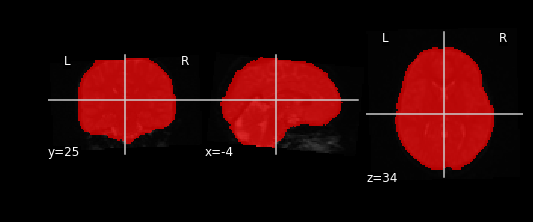

In [25]:
nip.plot_roi(mask_save_path, bg_img=b0_save_path, cmap=nip.cm.bwr_r)

# Estimate response function for CSD

The response function is an estimation based on the data of the signal produced by a single cohoerent bundle of fibers. We will use bundles with very high FA to generate this from our data.

In [26]:
response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)

csd_model = ConstrainedSphericalDeconvModel(gtab, response)

# Fit the data and calculate fiber directions

In [27]:
sphere = get_sphere('symmetric724')

csd_peaks = peaks_from_model(model=csd_model,
                             data=data,
                             sphere=sphere,
                             mask=mask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)

Check out our peaks on an axial slice by running this cell... a window will pop up 

(if you don't see a window pop up, then check if the variable interactive is set to True)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


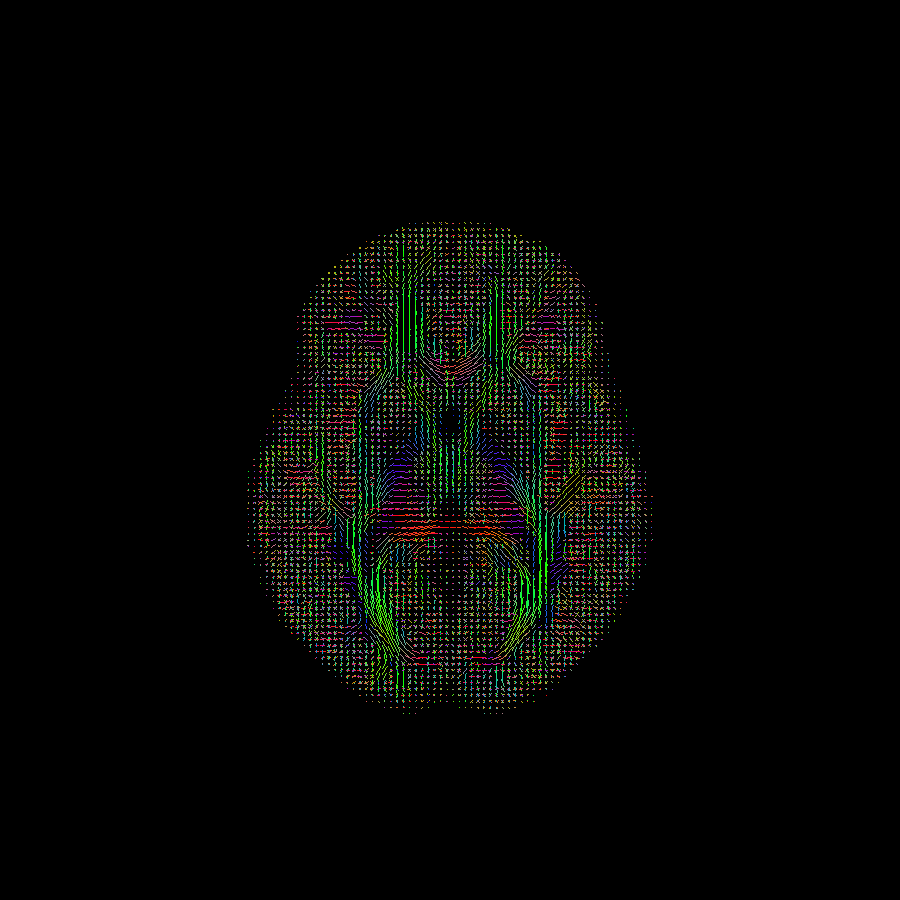

In [28]:
ren = window.Renderer()
ren.add(actor.peak_slicer(csd_peaks.peak_dirs,
                          csd_peaks.peak_values,
                          colors=None))

if interactive:
    window.show(ren, size=(900, 900))
else:
    window.record(ren, out_path='csd_direction_field.png', size=(900, 900))

Image('csd_direction_field.png')

# Fit the tensor model for the stopping condition (FA)

In [29]:
tensor_model = TensorModel(gtab, fit_method='WLS')
tensor_fit = tensor_model.fit(data, mask)

fa = tensor_fit.fa

# Our tissue classifier (gray/white/csf) uses FA

In [31]:
tissue_classifier = ThresholdTissueClassifier(fa, 0.1)

# Generate seeds to track from in voxels with high FA

Let's seed all of the voxels with FA greater than 0.3 with one seed

In [35]:
seeds = random_seeds_from_mask(fa > 0.3, seeds_count=1)

In [33]:
streamline_generator = LocalTracking(csd_peaks, tissue_classifier,
                                     seeds, affine=np.eye(4),
                                     step_size=0.5)

streamlines = Streamlines(streamline_generator)

Now let's check how many streamlines we generated

In [36]:
print(len(streamlines))

61556


We can take a look at our streamlines now

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


Saving illustration as det_streamlines.png


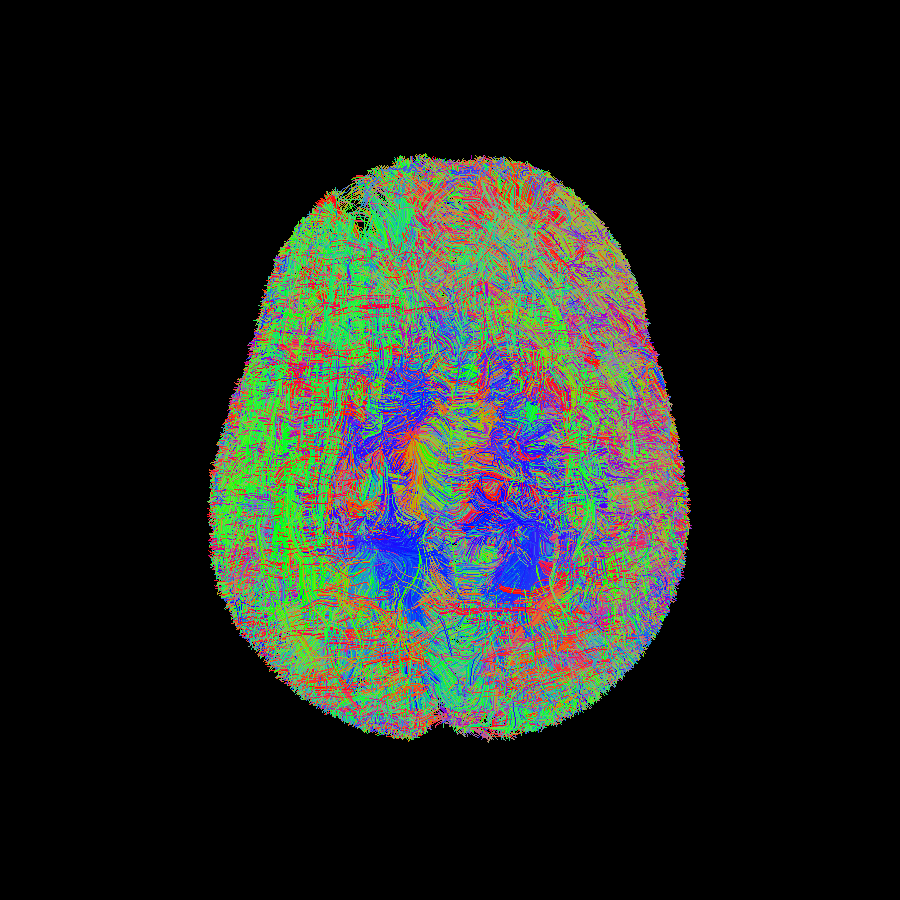

In [39]:
ren.clear()
ren.add(actor.line(streamlines))

if interactive:
    window.show(ren, size=(900, 900))
else:
    print('Saving illustration as det_streamlines.png')
    window.record(ren, out_path='det_streamlines.png', size=(900, 900))
    
Image('det_streamlines.png')

Save our wholebrain tractography dataset as a .trk file

In [ ]:
save_trk(Tractogram(streamlines, affine_to_rasmm=img.affine),
         'det_streamlines.trk')

save_nifti('fa_map.nii.gz', fa, img.affine)

This streamline dataset contains many streamlines that we are not interested in... there is a shell of short streamlines around the periphery of the brain that we know are an artifact of our tracking procedure... we can remove them with a length threhsold

In [41]:
# Calculate the length of each streamline in the dataset
lengths = list(length(streamlines))

# Set a threshold and create a new variable to store the long streamlines on
length_threshold = 20
long_streamlines = [] # initialize an empty list
for i,sl in enumerate(streamlines):
    if lengths[i] > length_threshold:
        long_streamlines.append(sl)

Save our new track

In [42]:
save_trk(Tractogram(long_streamlines, affine_to_rasmm=img.affine),
         'det_streamlines_long.trk')

Let's take a look at our long streamlines dataset

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


Saving illustration as det_streamlines_long.png


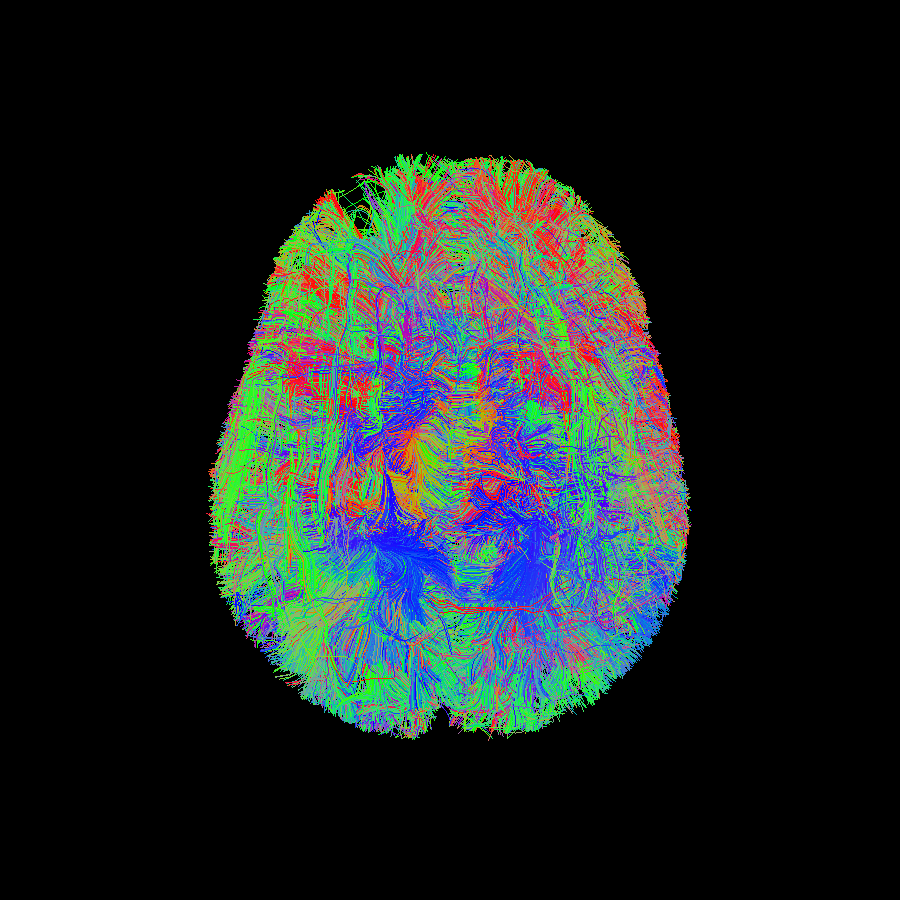

In [45]:
ren.clear()
ren.add(actor.line(long_streamlines))

if interactive:
    window.show(ren, size=(900, 900))
else:
    print('Saving illustration as det_streamlines_long.png')
    window.record(ren, out_path='det_streamlines_long.png', size=(900, 900))
    
Image('det_streamlines_long.png')